# Experimentation for creating a dataloader

In [ ]:
from collections.abc import Iterable, Iterator
from pathlib import Path
from typing import Literal

import albumentations as albs
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
from scipy.ndimage import gaussian_filter

## Class implementation

In [ ]:
class TrainingImgLoader:
    """Data loader for loading, enhancing and serving training images. The class itself
    is an Iterable, meaning it can be iterated over in for loops. The images are
    stored on the host, and only moved to the JAX devices when a batch is served. The
    JAX arrays containing the images are 4D, using (Batch, Y, X, Channel) index
    ordering.

    For example, for a given number of batches `nbatch`, and an instance of this class
    `loader`, you can iterate over batches of JAX arrays `batch`  using
    `for step, batch in zip(range(nbatch), loader):`."""

    # Required instance attributes.
    _arrays: np.ndarray
    _batch_size: int
    _normalize: bool
    _zoomf: tuple[float, float] | None
    _bkgf: tuple[float, float] | None
    _pbkg: float
    _blur: float | None
    _rotate: bool
    _fliph: bool
    _flipv: bool
    _albs_transform: albs.Compose | None
    _seed: int | None

    # Class attributes.
    _ALLOWED_READ_MODES: tuple[str, ...] = ("NUMPY",)

    def __init__(
        self,
        files: Iterable[Path | str],
        *,
        batch_size: int,
        normalize: bool = True,
        zoomf: tuple[float, float] | None = None,
        bkgf: tuple[float, float] | None = None,
        pbkg: float = 1.0,
        blur: float | None = None,
        rotate: bool = True,
        fliph: bool = True,
        flipv: bool = True,
        seed: int | None = None,
        read_mode: Literal["NUMPY"] = "NUMPY",
    ) -> None:
        r"""**Arguments**

        - `batch_size`: Size of batches to return.
        - `normalize`: Whether to normalize images to the signed unit interval
            $[-1, 1]$.
        - `files`: Sequence of filepaths to images stored on disk.
        - `zoomf`: Range of factor to randomly zoom the images in by. Negative factors
            correspond to zooming out, postive factors to zooming in (e.g. `- 0.1`)
            corresponds to a 10% zoom-out.
        - `bkgf`: Range of factor of contribution for an additional background flux
            component. If set, an additional uniform flux level will be added to each
            pixel, such that the sum of this additional component accounts for
            `bkgf * 100` percent of the total final image flux. Defaults to None, in
            which case no background flux will be added.
        - `pbkg`: Probability of adding an overresolved flux contribution to the batched
            images. This defaults to a value of 1.0 (i.e. 100%).
        - `blur`: Standard deviation by which to convolve the original images using a
            Gaussian kernel. Can be useful for smoothing out edge/noise artefacts from
            training images. This convolution is applied when loading in the original
            images, i.e. before any other augmentation.
        - `rotate`: Randomly rotate input images.
        - `fliph`: Randomly flip images horizontally.
        - `flipv`: Randomly flip images vertically.
        - `seed`: RNG seed to be used in all randomisation of data augmentations,
            including those handled by numpy and by albumentations. Setting this
            seed will cause the batches of images produced by the object to be
            deterministic each time.
        - `read_mode`: How to interpret image files stored on disk. E.g. `NUMPY` to read
            serialized Numpy arrays in .npy files."""
        # Direct initialisation.
        self._batch_size = batch_size
        self._normalize = normalize
        self._zoomf = zoomf
        self._bkgf = bkgf
        self._pbkg = pbkg
        self._rotate = rotate
        self._blur = blur
        self._fliph, self._flipv = fliph, flipv
        self._seed = seed

        # Validate read mode
        if read_mode not in self._ALLOWED_READ_MODES:
            raise ValueError(
                f"Read method {read_mode} is not supported."
                f"Supported options are: {', '.join(self._ALLOWED_READ_MODES)}"
            )

        # Initialise albumentation transformations.
        self._set_albumentation_transform(seed=self._seed)

        # Reading in arrays (3D array shape ->  (Y, X, Channel) index ordering).
        files = [Path(file) for file in files]  #  Cast to Path if needed.
        img_list = []
        img_shape = None
        for file in files:
            img = self._read_img(file, read_mode)
            img_list.append(img)
            if (np.shape(img) != img_shape) and (img_shape is not None):
                raise ValueError(
                    f"Inconsistent shape of the current image: {np.shape(img)}."
                    f"The previous image's shape is: {img_shape}."
                )
            else:
                img_shape = np.shape(img)

        # Blur all the images in the (mutable) list.
        if self._blur is not None:
            img_list = self._blur_image_list(img_list)

        # Assign image arrays (4D array -> (Batch, Y, X, Channel) index ordering).
        # NOTE: these arrays are still stored on the host as numpy arrays. The move to
        # the JAX device is performed per batch.
        self._arrays = np.stack(img_list, axis=0)

    @staticmethod
    def _read_img(file: Path, read_mode: str) -> np.ndarray:
        """Master method to load in an image from a file stored on disk. The array
        should have a 3D shape, with (Y, X, Channel) index ordering."""
        if read_mode == "NUMPY":
            img = TrainingImgLoader._read_img_numpy(file)
        else:
            raise ValueError(f"Read mode {read_mode} is not supported.")
        if img.ndim != 3:
            raise ValueError(
                "Loaded images should have 3D shape (index ordering -> Y, X, Channel)."
                f"Instead found number of dimensions {img.ndim} for file {file}."
            )
        return img

    @staticmethod
    def _read_img_numpy(file: Path) -> np.ndarray:
        """Read in a numpy image array stored on disk."""
        img = None
        with open(file, "rb") as f:
            img = np.load(f)
        return img

    def _blur_image_list(self, array_list: list[np.ndarray]) -> list[np.ndarray]:
        """Take in a list of 3D numpy array images, and blur them with a Gaussian
        kernel of the appropriate size of pixels. The individual image arrays should
        have a 3D shape, with (Y, X, Channel) index ordering. Blurring is performed
        in-place."""
        for arr in array_list:
            for i in range(np.shape(arr)[2]):
                gaussian_filter(
                    arr[:, :, i], (self._blur, self._blur), output=arr[:, :, i]
                )  # Convolve channels in-place
        return array_list

    @staticmethod
    def _map_from_unit_signed_to_unit_interval(img_arr: np.ndarray) -> np.ndarray:
        r"""Map an image array defined in the signed unit interval $[-1, 1]$ to
        the unsigned unit interval $[0, 1]$ (0 is meant to indicate zero flux, and 1
        meant to indicate maximum flux in the image)."""
        return (img_arr + 1) / 2

    @staticmethod
    def _map_from_unit_to_unit_signed_interval(img_arr: np.ndarray) -> np.ndarray:
        r"""Map an image array defined in the unsigned unit interval $[0, 1]$ to
        the signed unit interval $[-1, 1]$ (-1 is meant to indicate zero flux, and 1
        meant to indicate maximum flux in the image)."""
        return (img_arr * 2) - 1

    def __iter__(self) -> Iterator[jax.Array]:
        """Returns a generator which yields batches of images as a JAX array.

        **Returns:**

        A generator yielding 4D JAX arrays containing the images, using (Batch, Y, X,
        Channel) index ordering. The batched images are enhanced according to the
        various attributes set in the `TrainingImgLoader` instance."""
        dataset_size = self._arrays.shape[0]

        # Numpy RNG generator for batch enhancement.
        rng_gen = nr.default_rng(seed=self._seed)

        # Keep continuously feeding epochs.
        idxs = np.arange(dataset_size)
        while True:
            perm_idxs = rng_gen.permutation(idxs)  # Permute dataset indices.

            # Loop over batches in single epoch.
            start = 0
            end = self._batch_size
            while end < dataset_size:
                batch_idxs = perm_idxs[start:end]  # Image indices for current batch.
                img_batch = np.copy(self._arrays[batch_idxs])  # Make a deep copy.
                # Note that the batch enhancement should be thought of as a function
                # that consumes a JAX RNG key.
                img_batch = self._enhance_batch(
                    img_batch, rng_gen=rng_gen, normalize=self._normalize
                )

                yield jnp.array(img_batch)

                start = end  # Set state for next batch.
                end = start + self._batch_size

    def _set_albumentation_transform(self, seed: int | None) -> None:
        """Sets the albumnentation transform attribute to be used during data
        enhancement."""
        transforms = []
        if self._fliph:
            transforms.append(albs.HorizontalFlip(p=0.5))
        if self._flipv:
            transforms.append(albs.VerticalFlip(p=0.5))
        if self._rotate or self._zoomf is not None:  # Affine for rotation and zoom.
            if self._rotate:
                rot_lims = (0.0, 360.0)
            else:
                rot_lims = 0.0
            if self._zoomf is not None:
                scale_lims = (1.0 + self._zoomf[0], 1.0 + self._zoomf[1])
            else:
                scale_lims = (1.0, 1.0)

            transforms.append(
                albs.Affine(
                    scale=scale_lims,
                    rotate=rot_lims,
                    interpolation=1,  # Linear interpolation (0 for nearest neighbor).
                    fit_output=False,  # Do not force fitting of tranformed image.
                    keep_ratio=True,  # Keep original aspect ratio.
                    rotate_method="largest_box",
                    balanced_scale=True,  # Ensure balanced scaling factor sampling.
                    border_mode=0,  # Fill in border with constant.
                    fill=0.0,  # Border fill constant value.
                    p=1.0,  # Always apply.
                )
            )
        if transforms == []:
            self._albs_transform = None
        else:
            self._albs_transform = albs.Compose(transforms, seed=self._seed)
        return

    def _enhance_batch(
        self, img_batch: np.ndarray, *, rng_gen: nr.Generator, normalize: bool
    ) -> np.ndarray:
        """Enhance a batch of images, passed along as a 4D numpy array (index ordering
        -> Batch, Y, X, Channel). Enhancement is performed in-place. It uses a numpy
        RNG generator to perform any random operations needed."""
        # Loop over 3D images in batch.
        nbatch = np.shape(img_batch)[0]
        for i_img in range(nbatch):
            # Apply albumentations transform to each 3D image array (note the output of
            # Compose is a dict).
            if self._albs_transform is not None:
                img_batch[i_img, :, :, :] = self._albs_transform(
                    image=img_batch[i_img, :, :, :]
                )["image"]

        # Apply additional background flux to each channel.
        if self._bkgf is not None:
            # Uniform numbers to decide if to apply background flux.
            uniform_rand = rng_gen.uniform(size=(nbatch,))
            # Loop over 3D images in batch.
            for i_img in range(nbatch):
                if uniform_rand[i_img] < self._pbkg:
                    # If background is to be applied, randomly take background strength
                    # within limits.
                    bkg_factor = rng_gen.uniform(low=self._bkgf[0], high=self._bkgf[1])
                    # Apply to each image channel.
                    for i_ch in range(img_batch.shape[3]):
                        img_batch[i_img, :, :, i_ch] += (
                            np.max(img_batch[i_img, :, :, i_ch]) * bkg_factor
                        )

        # Apply normalization to the signed unit interval [-1, 1].
        if self._normalize:
            # Loop over 3D images in batch.
            for i_img in range(nbatch):
                for i_ch in range(img_batch.shape[3]):
                    img_batch[i_img, :, :, i_ch] /= np.max(img_batch[i_img, :, :, i_ch])
                    img_batch[i_img, :, :, i_ch] = (
                        self._map_from_unit_to_unit_signed_interval(
                            img_batch[i_img, :, :, i_ch]
                        )
                    )

        return img_batch

## Example

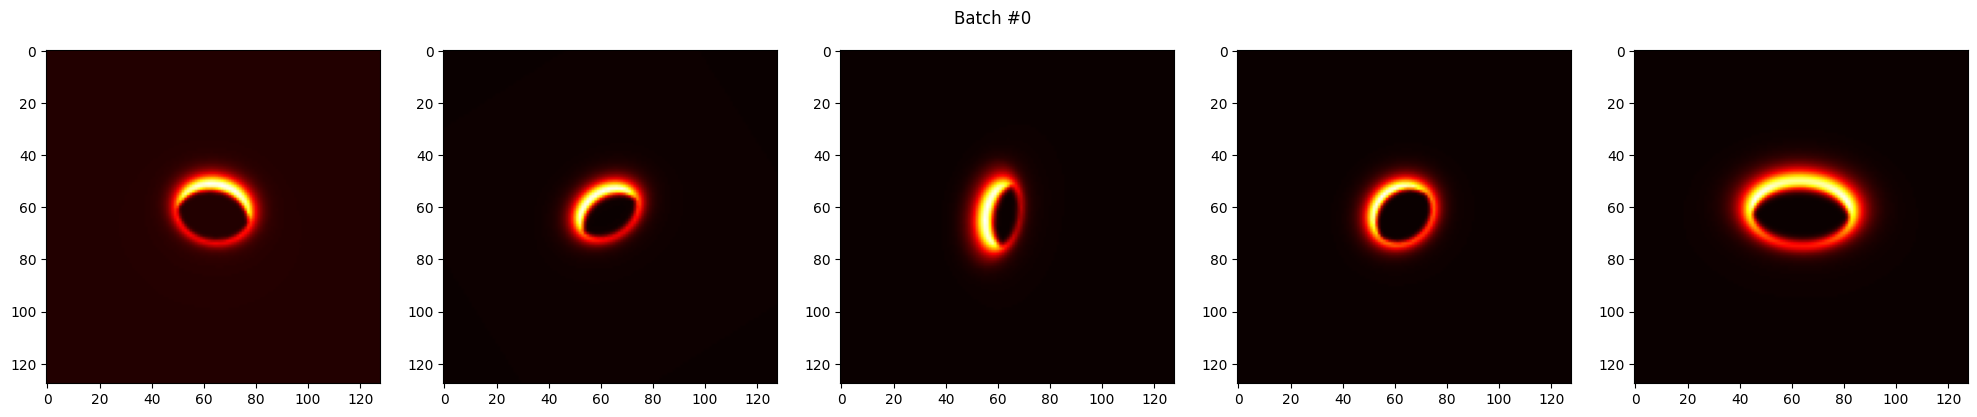

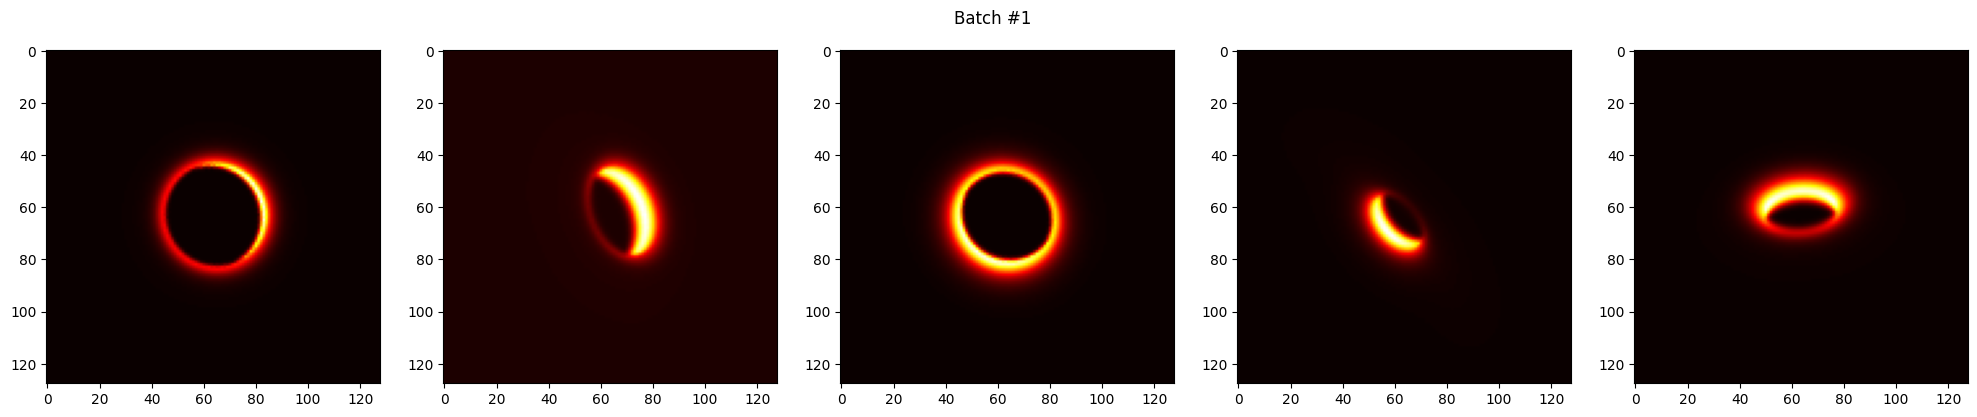

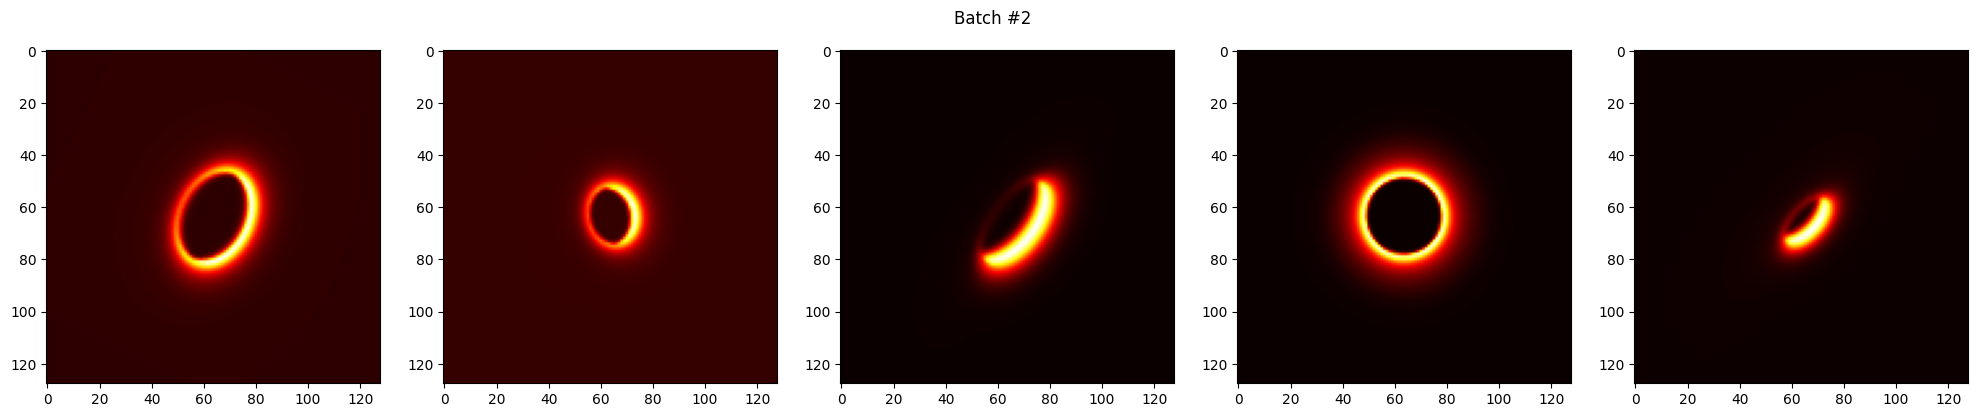

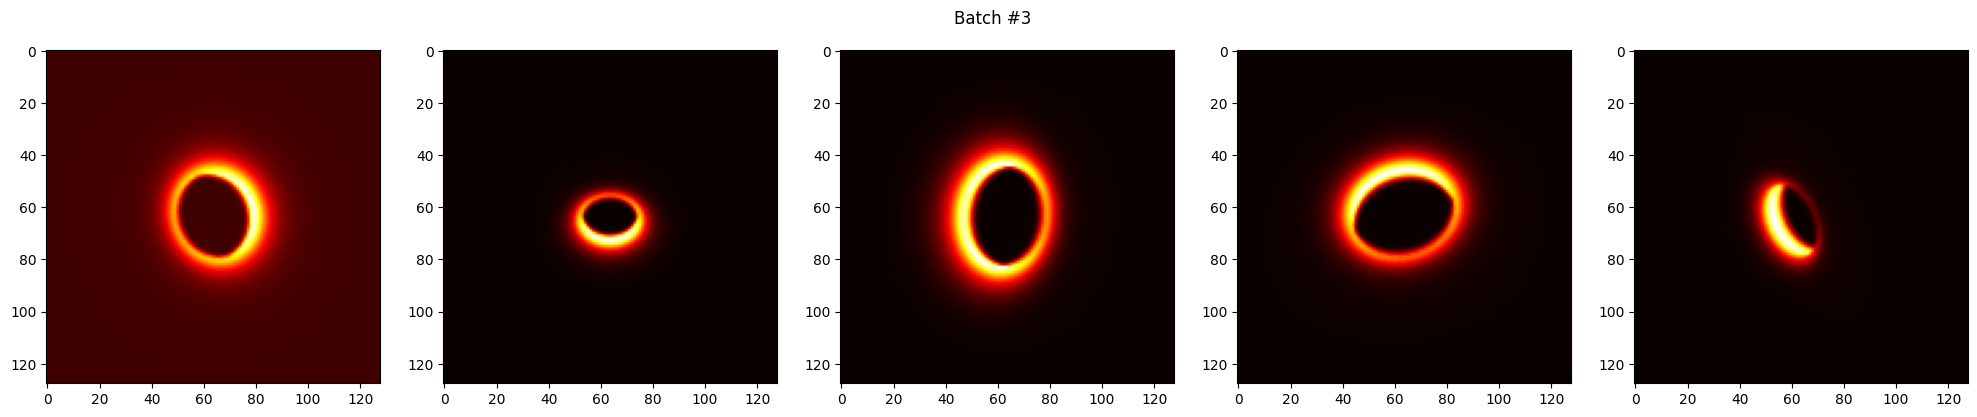

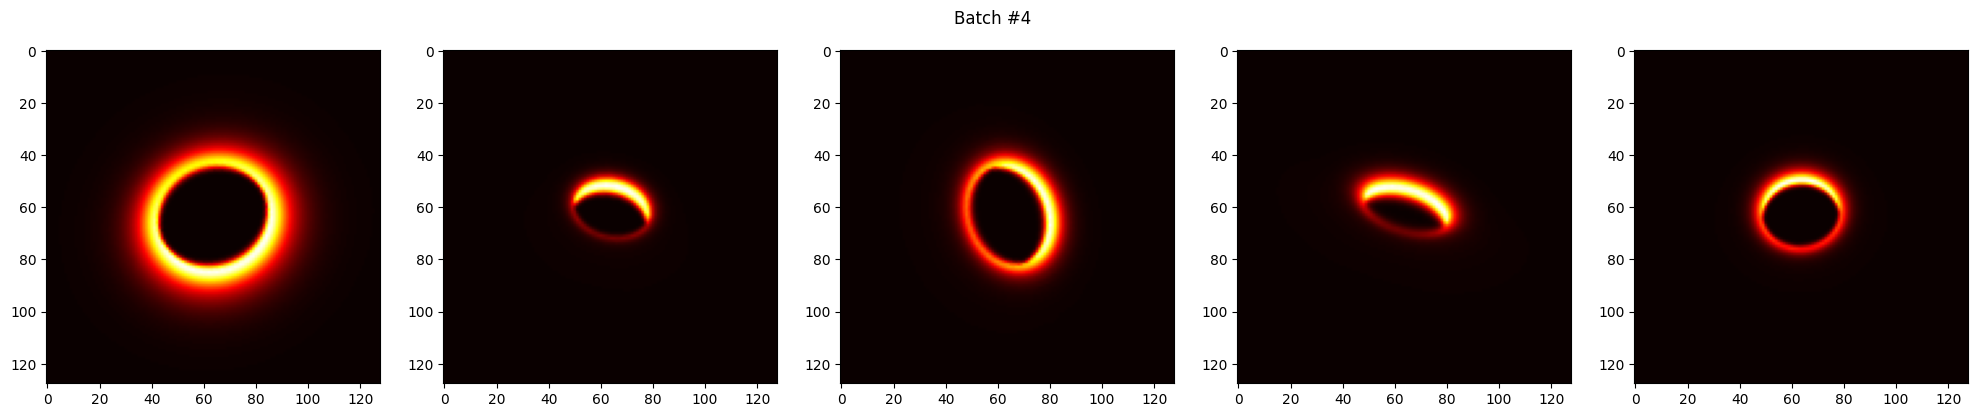

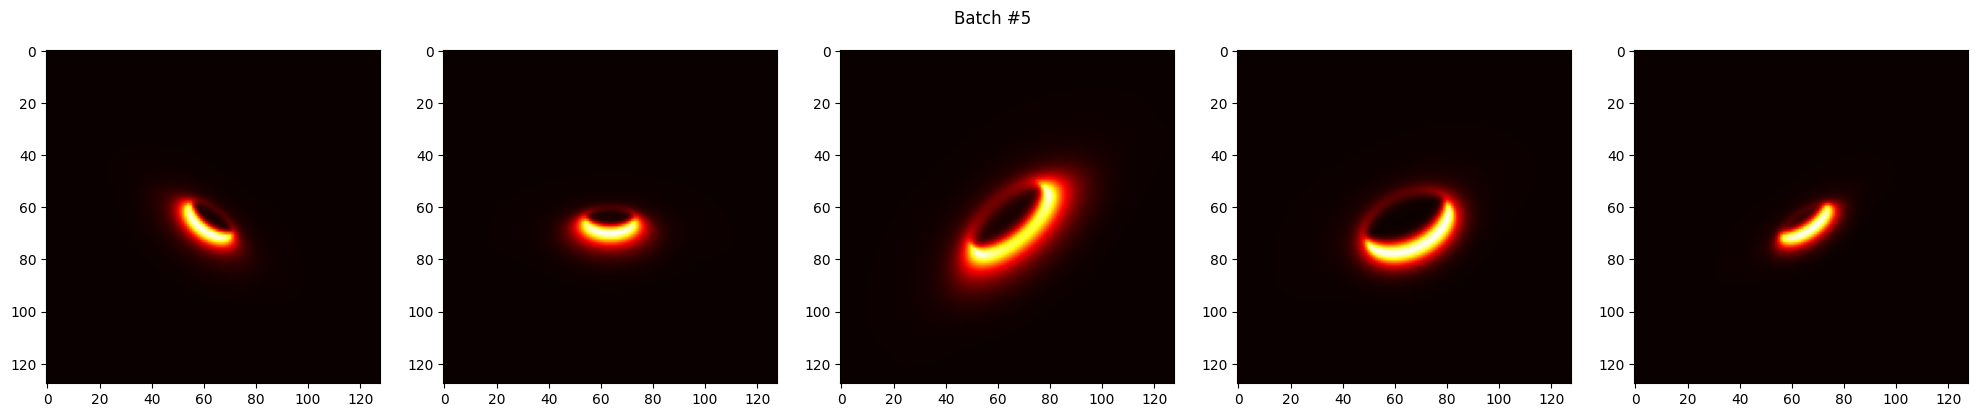

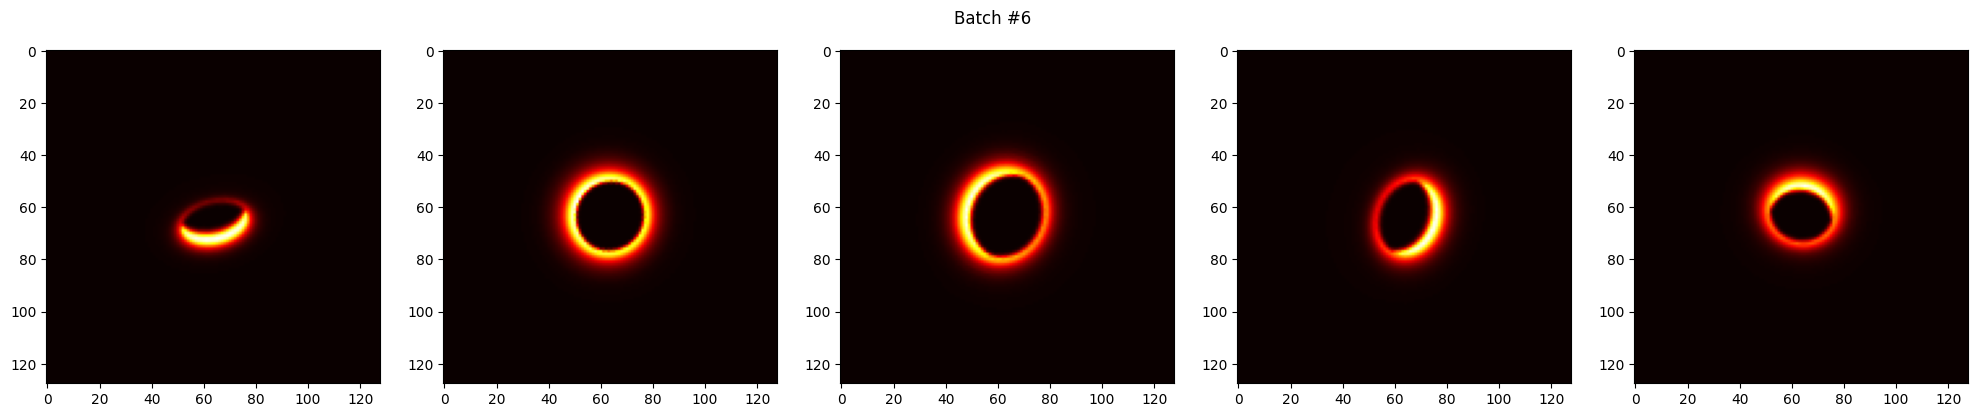

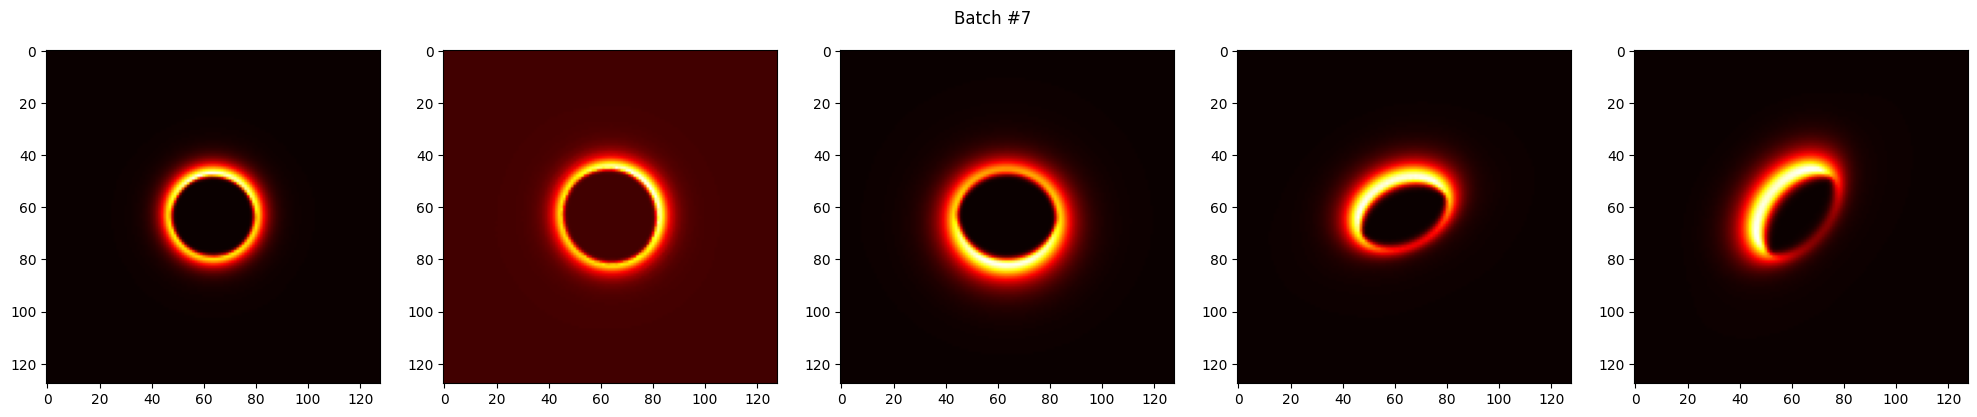

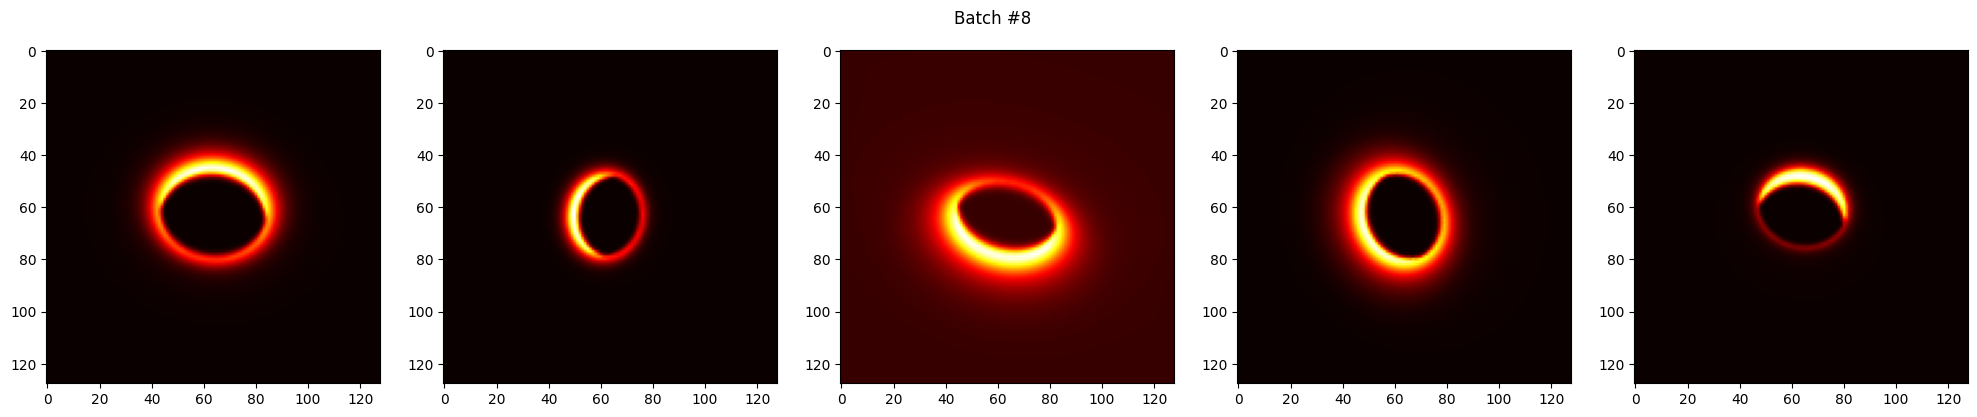

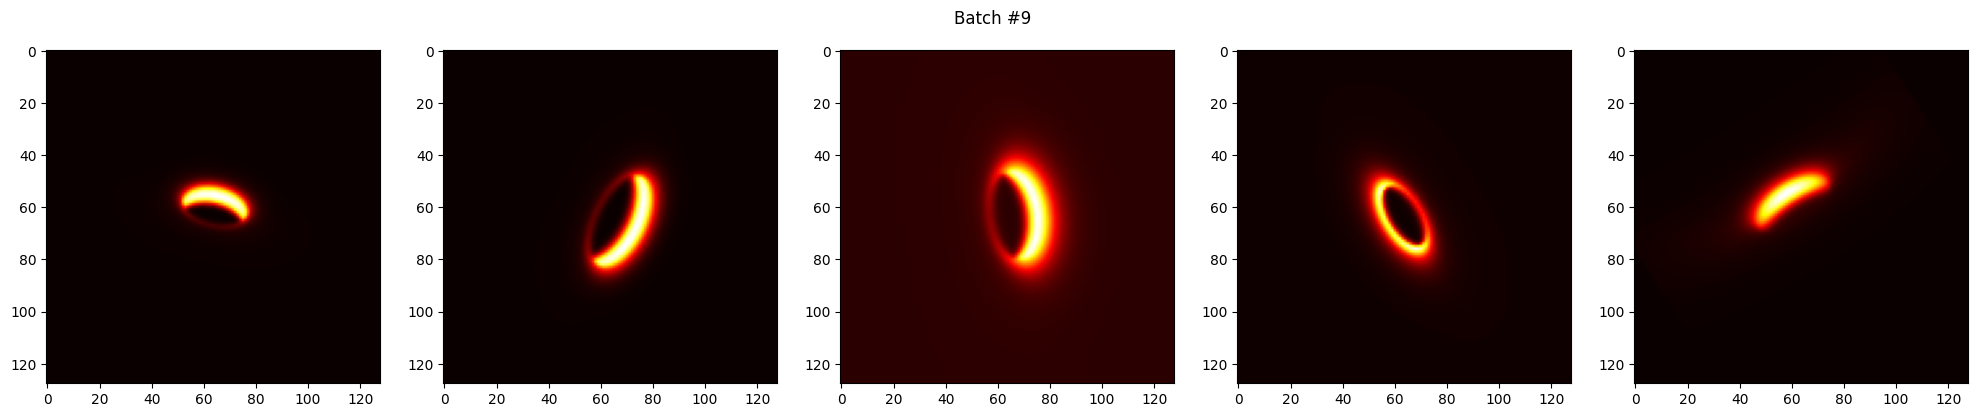

In [3]:
directory = """/home/toond/Documents/phd/paper_matisse_imaging/training_data/\
discs_mcfost/runs/ozstar_2zone_cont_training_set/saved_imgs"""

files = sorted(Path(directory).glob("*.npy"))

loader = TrainingImgLoader(
    files,
    batch_size=5,
    normalize=True,
    zoomf=(-0.1, 0.1),
    bkgf=(0.00, 0.10),
    pbkg=0.25,
    blur=0.5,
    rotate=True,
    fliph=True,
    flipv=True,
    read_mode="NUMPY",
    seed=42,
)

# For a generator function, have to zip (which truncates to the shortest of iterables)
# with e.g. a range to limit steps.
nbatch = 10
for step, batch in zip(range(nbatch), loader):
    batch_size = np.shape(batch)[0]
    fig, ax = plt.subplots(1, batch_size, figsize=(batch_size * 4, 4))
    for i in range(batch_size):
        ax[i].imshow(
            batch[i, :, :, 0], cmap="hot", vmin=-1, vmax=jnp.max(batch[i, :, :, 0])
        )
    fig.suptitle(f"Batch #{step}")
    plt.tight_layout()
    plt.show()

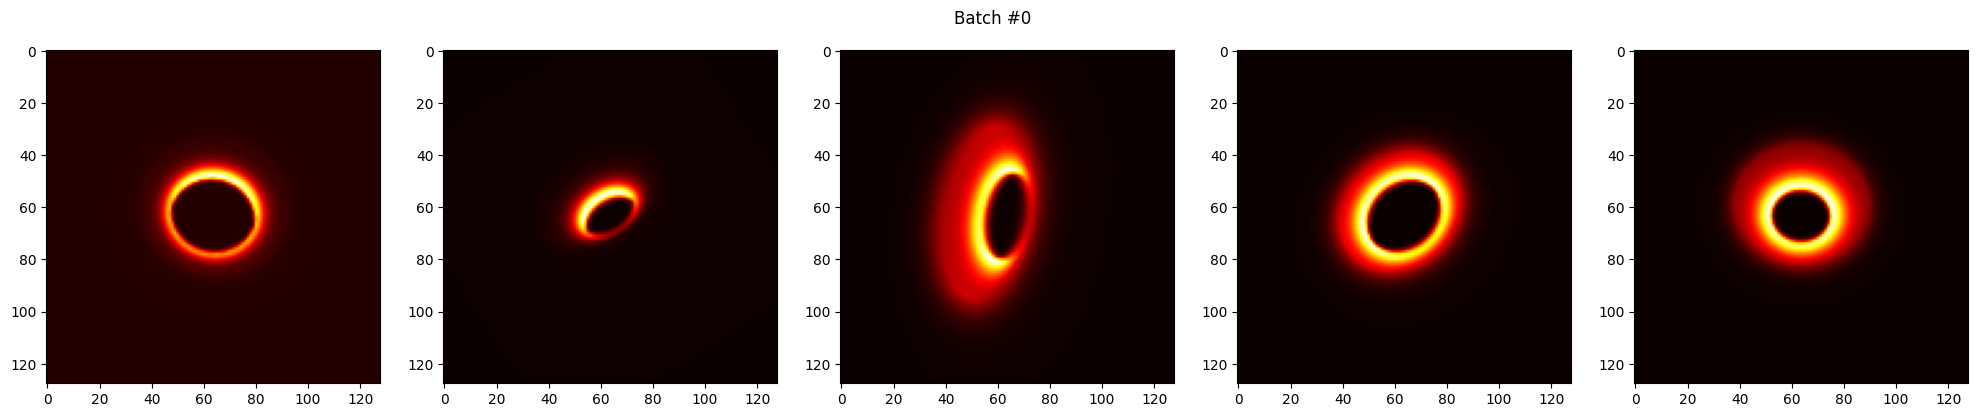

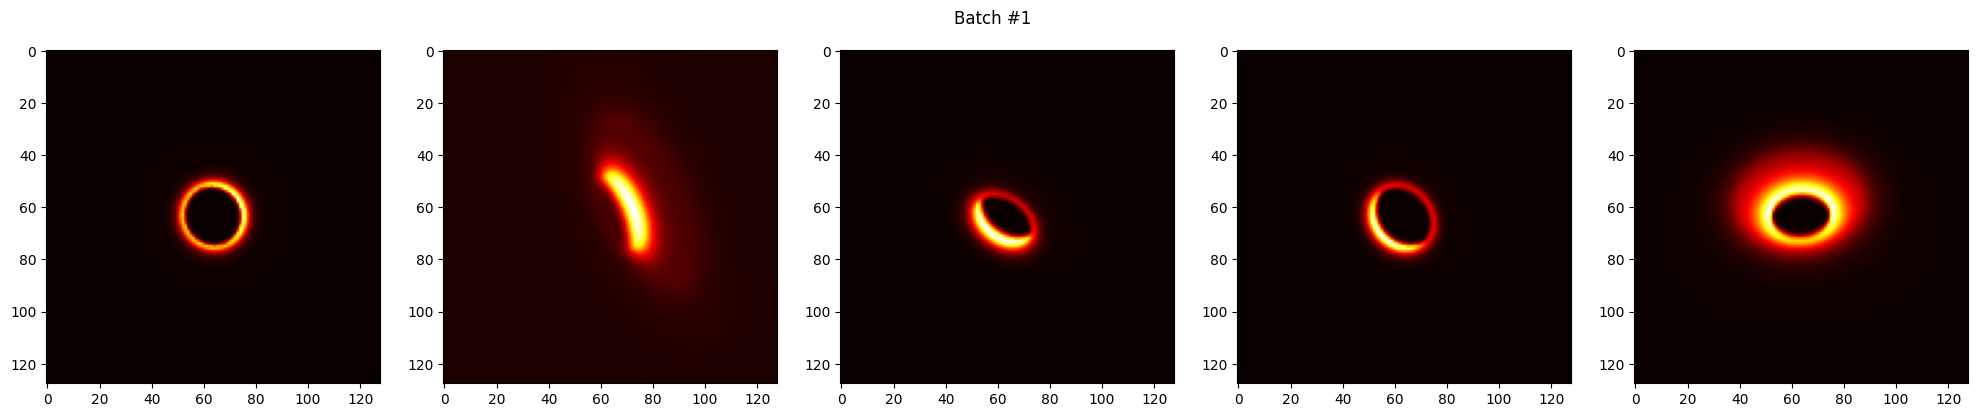

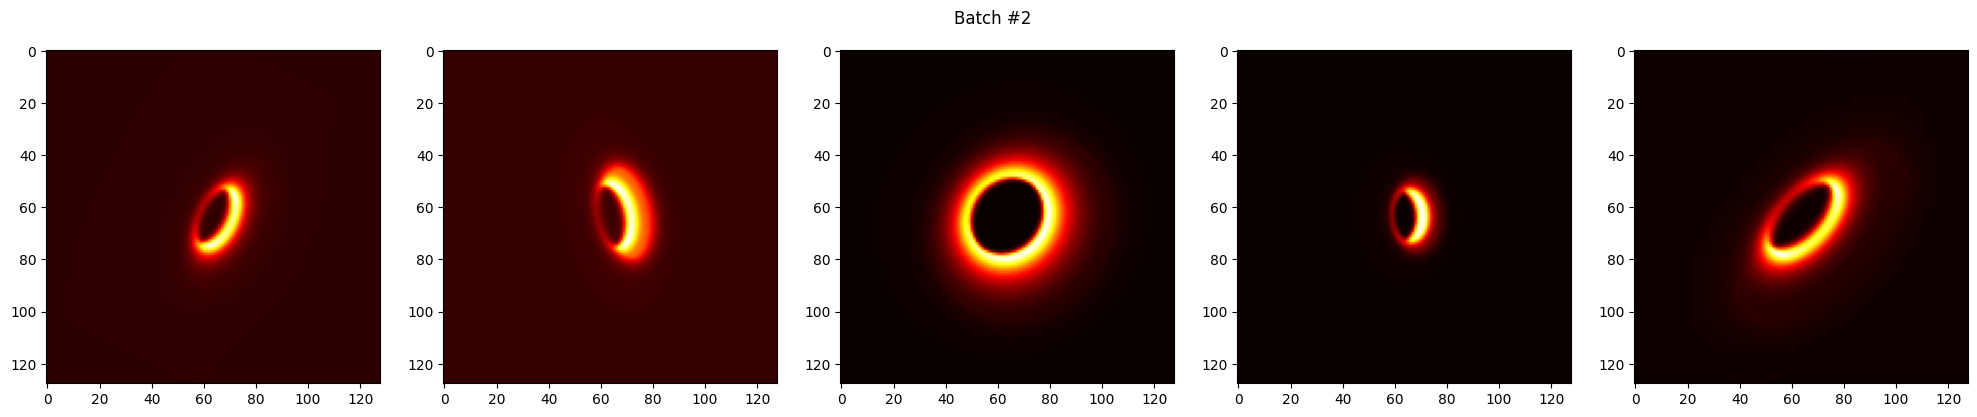

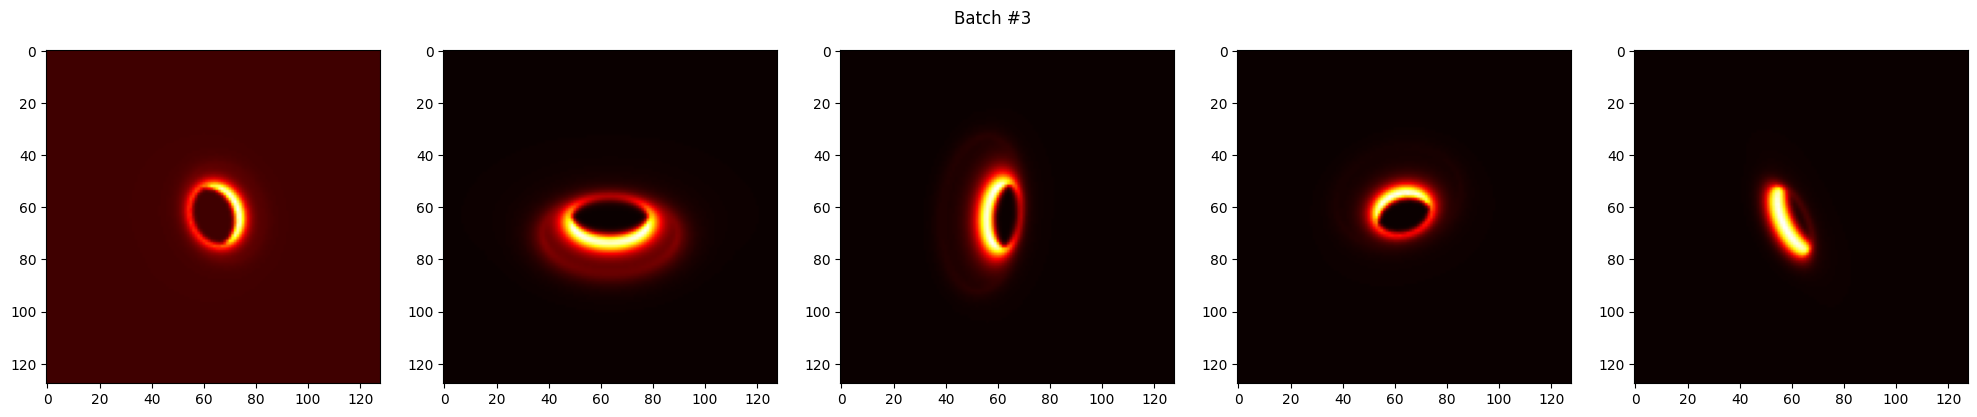

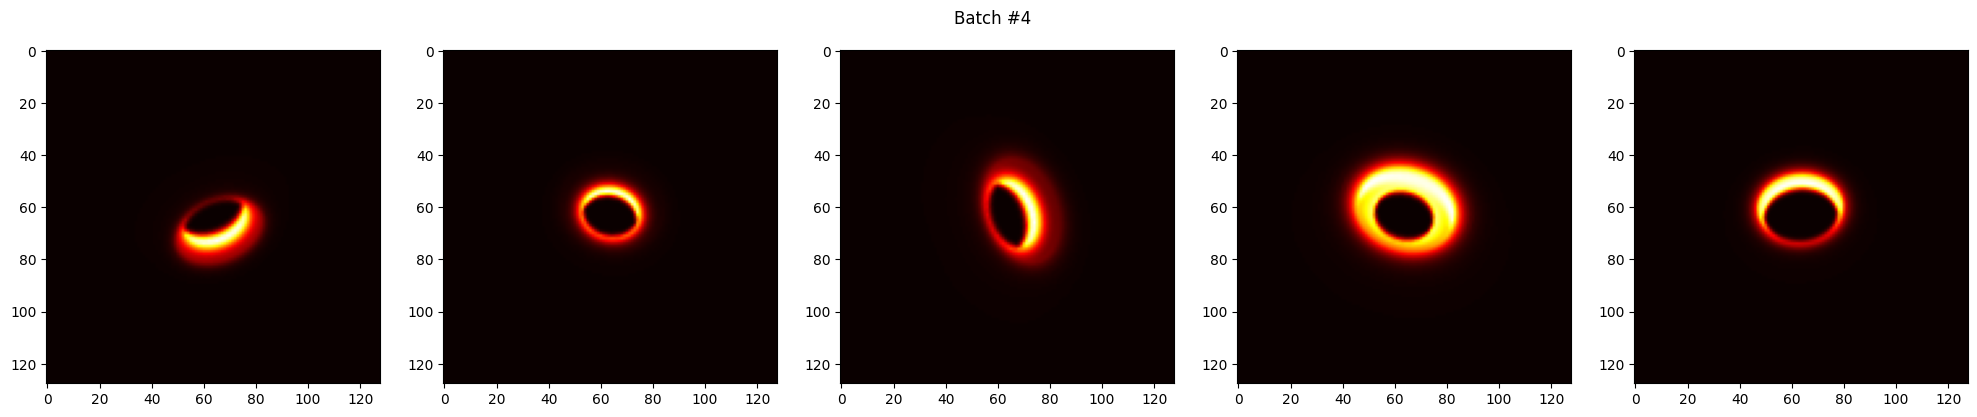

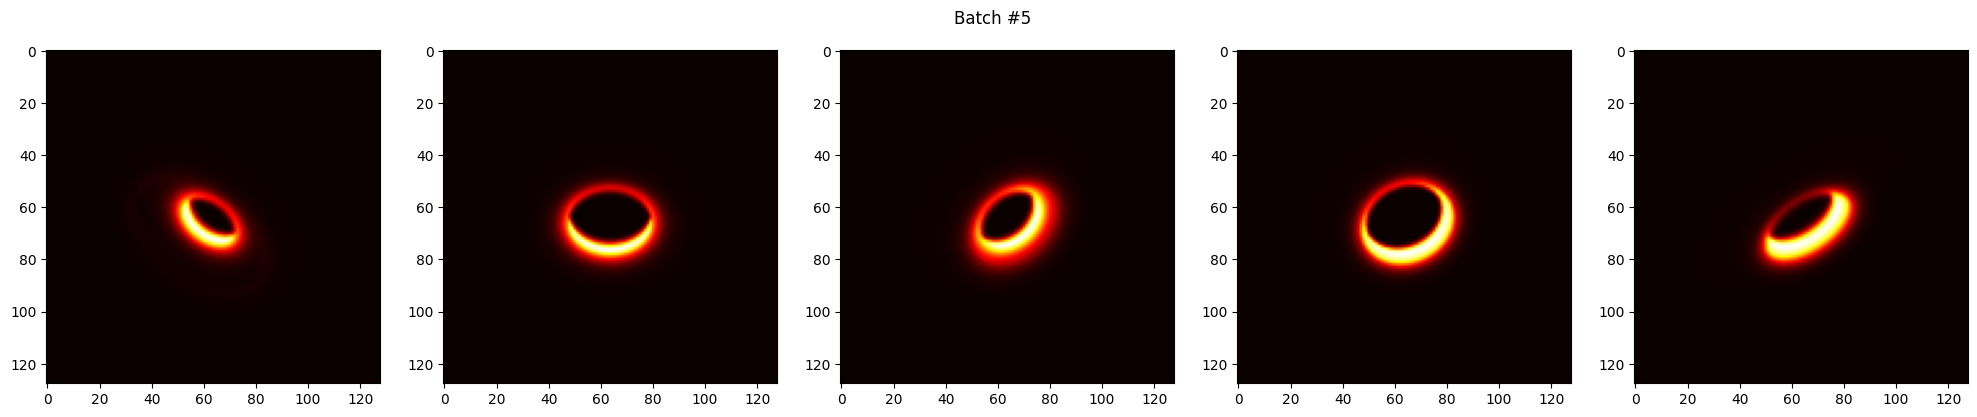

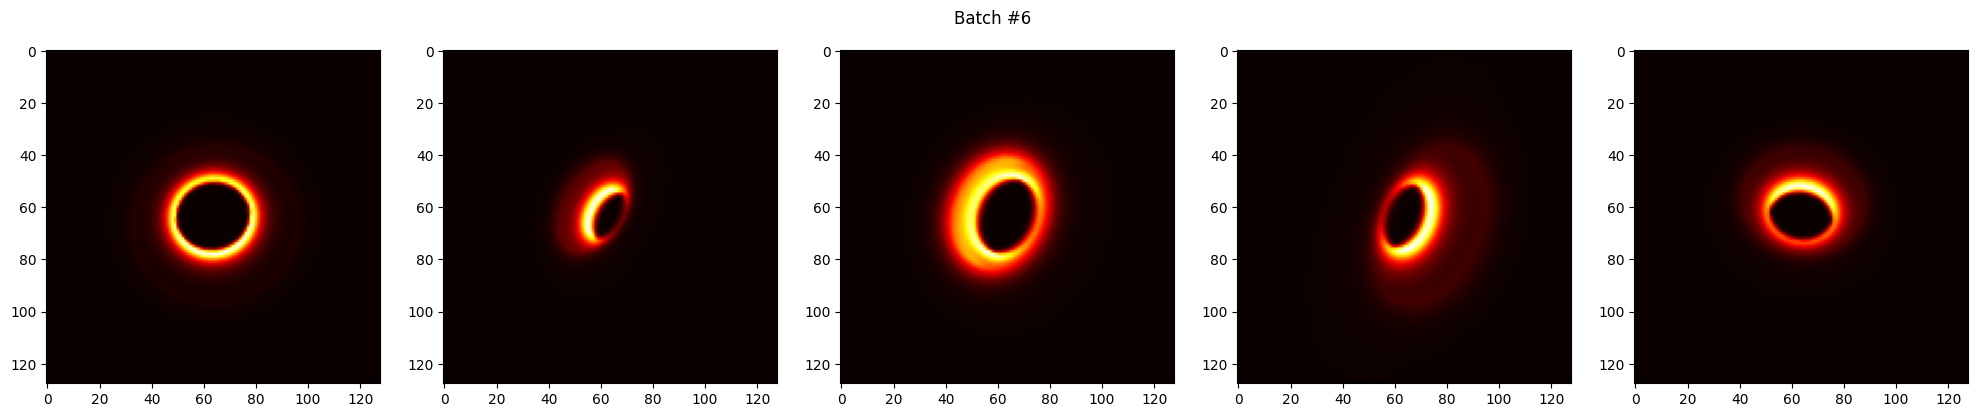

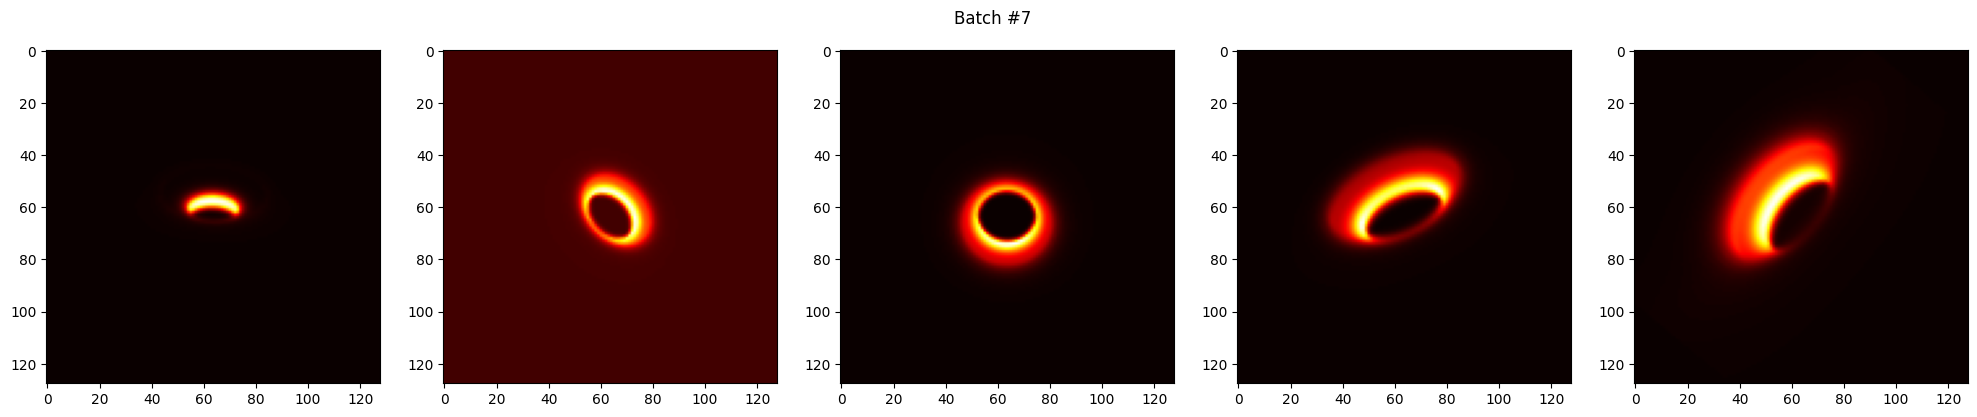

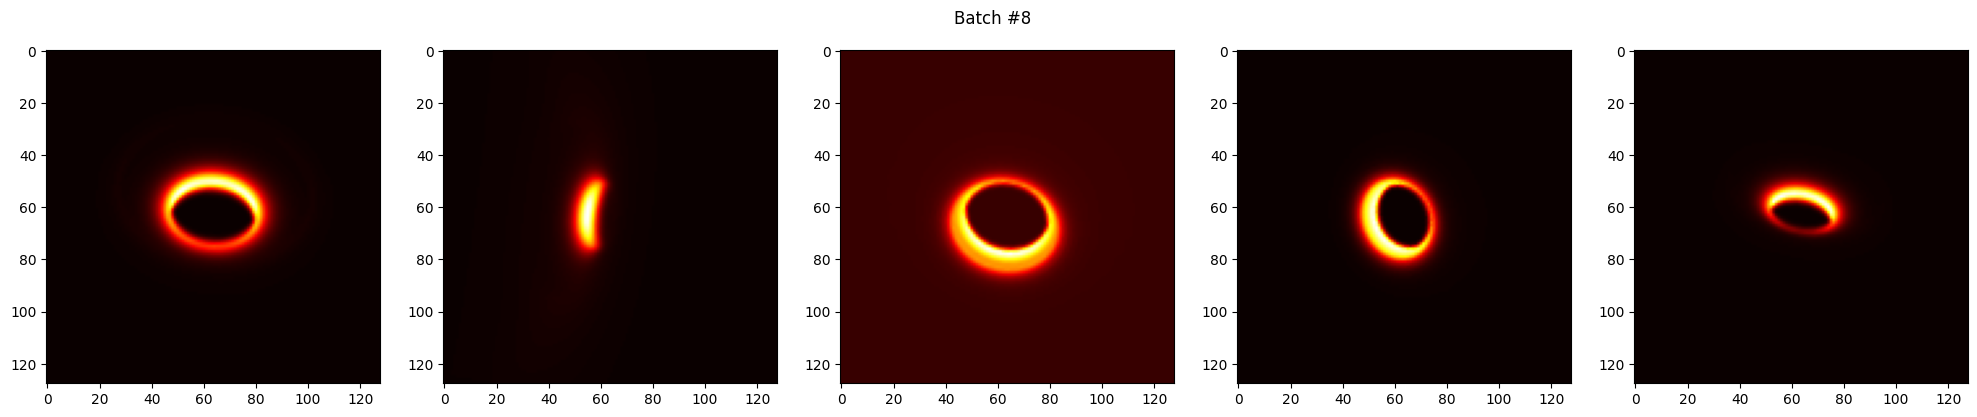

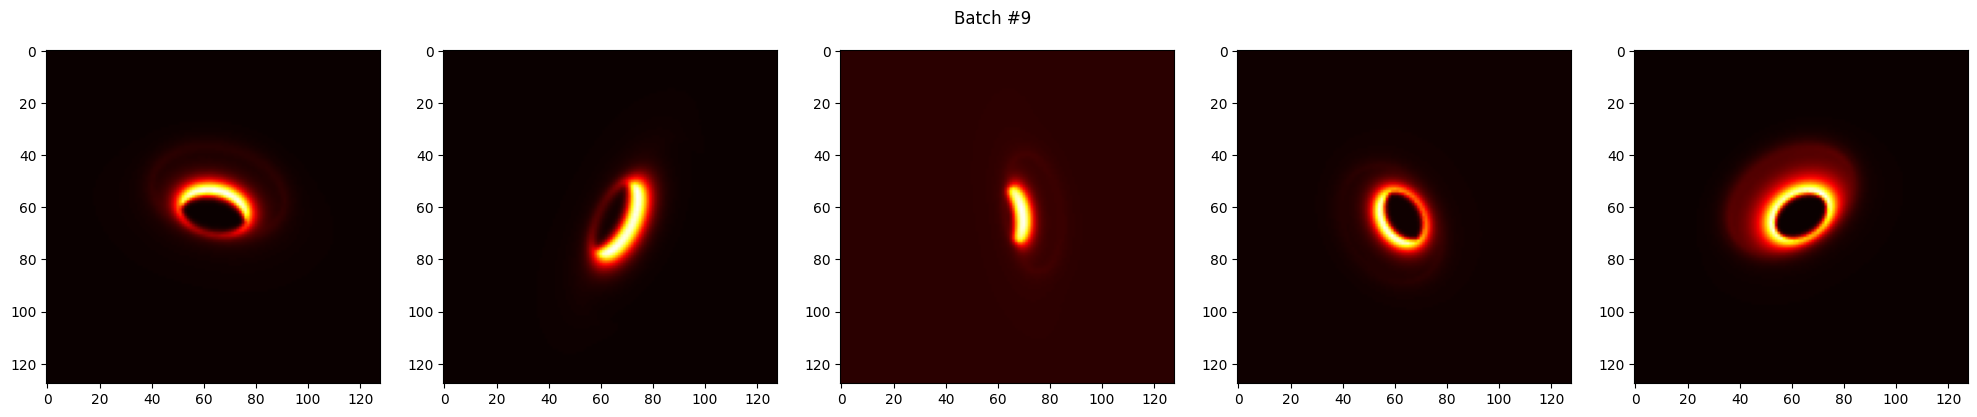

In [4]:
directory = """/home/toond/Documents/phd/paper_matisse_imaging/training_data/\
discs_mcfost/runs/ozstar_2zone_sig_bump_training_set/saved_imgs"""

files = sorted(Path(directory).glob("*.npy"))

loader = TrainingImgLoader(
    files,
    batch_size=5,
    normalize=True,
    zoomf=(-0.1, 0.1),
    bkgf=(0.00, 0.10),
    pbkg=0.25,
    blur=0.5,
    rotate=True,
    fliph=True,
    flipv=True,
    read_mode="NUMPY",
    seed=42,
)

# batch_generator = loader.get_batch_generator(5, normalize=True)

# For a generator function, have to zip (which truncates to the shortest of iterables)
# with e.g. a range to limit steps.
nbatch = 10
for step, batch in zip(range(nbatch), loader):
    batch_size = np.shape(batch)[0]
    fig, ax = plt.subplots(1, batch_size, figsize=(batch_size * 4, 4))
    for i in range(batch_size):
        ax[i].imshow(
            batch[i, :, :, 0], cmap="hot", vmin=-1, vmax=jnp.max(batch[i, :, :, 0])
        )
    fig.suptitle(f"Batch #{step}")
    plt.tight_layout()
    plt.show()

In [5]:
%timeit for step, batch in zip(range(1), loader): pass

1.4 ms ± 68.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
